In [1]:
from pathlib import Path

import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
import rioxarray
import pdal
from dask.distributed import Client

from forest_structure_tools.metrics import forest_structure_metrics

In [2]:
data_dir = Path('../data/outputs')
sites_dir = data_dir / "sites"
sites_lidar_dir = sites_dir / "lidar"

plots_dir = data_dir / "plots"
plots_metrics_dir = plots_dir / "metrics"
plots_netcdf_output_dir = plots_metrics_dir / "x1-y1-z1" / "net_cdf"

plots_netcdf_output_dir.mkdir(parents=True, exist_ok=True)

In [3]:
plots = gpd.read_file(plots_dir / "plots.geojson")
plots = plots.set_index("id")
plots

,site,plot_number,site_plot_id,geometry
id,,,,
AGG_O_01_P1,AGG_O_01,1,AGG_O_01_P1,"POLYGON ((463042.83 5259846.736, 463025.797 52..."
AGG_O_01_P2,AGG_O_01,2,AGG_O_01_P2,"POLYGON ((463124.556 5259819.234, 463116.068 5..."
AGG_O_01_P3,AGG_O_01,3,AGG_O_01_P3,"POLYGON ((463201.174 5259815.806, 463200.551 5..."
AGG_O_01_P4,AGG_O_01,4,AGG_O_01_P4,"POLYGON ((463257.777 5259801.962, 463245.303 5..."
AGG_O_01_P5,AGG_O_01,5,AGG_O_01_P5,"POLYGON ((463303.022 5259789.552, 463289.794 5..."
...,...,...,...,...
ULY_Y_96_P1,ULY_Y_96,1,ULY_Y_96_P1,"POLYGON ((455348.476 5275834.517, 455348.154 5..."
ULY_Y_96_P2,ULY_Y_96,2,ULY_Y_96_P2,"POLYGON ((455296.576 5275837.224, 455299.223 5..."
ULY_Y_96_P3,ULY_Y_96,3,ULY_Y_96_P3,"POLYGON ((455252.092 5275834.16, 455248.849 52..."


In [4]:
def read_points(input_path: str, polygon_wkt: str):
    pl = pdal.Reader(
        str(input_path), type="readers.copc", polygon=polygon_wkt
    ) | pdal.Filter(type="filters.range", limits="Classification[0:5]")
    count = pl.execute()
    print(f"Read in {count:,d} points")
    return pl.arrays[0]


def calculate_metrics(points: np.ndarray):
    metrics = forest_structure_metrics(
        points,
        xy_bin_size=1,
        z_bin_size=1,
    )

    # Add coordinate reference system and spatial dimensions
    metrics.rio.write_crs(7855, inplace=True)
    metrics.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
    metrics.rio.write_coordinate_system(inplace=True)

    # Transpose for plotting and exporting to GeoTiffs

    metrics = metrics.transpose("y", "x", "z")

    return metrics


def calculate_metrics_for_plot(plot_id: str):
    plot = plots.loc[plot_id]
    polygon_wkt = plot.geometry.buffer(2).wkt
    input_path = sites_lidar_dir / f"{plot.site}.copc.laz"
    points = read_points(input_path, polygon_wkt)

    metrics = calculate_metrics(points)
    metrics.attrs["plot_id"] = plot_id

    metrics = metrics.rio.clip([plot.geometry])

    return metrics


def calculate_and_save_metrics_for_plot(plot_id: str):
    # Add import in here so Dask knows to import it
    import rioxarray
    
    metrics = calculate_metrics_for_plot(plot_id)
    metrics.to_netcdf(plots_netcdf_output_dir / f"{plot_id}.nc")
    metrics.close()

    grid_size = metrics["chm"].size
    vox_size = metrics["vox_inside"].size
    return (grid_size, vox_size)

In [5]:
test_metrics = calculate_metrics_for_plot("NRM_O_19_P3")
test_metrics

Read in 211,385 points


<xarray.Dataset> Size: 16MB
Dimensions:               (x: 71, y: 70, z: 36)
Coordinates:
  * x                     (x) float64 568B 4.528e+05 4.528e+05 ... 4.528e+05
  * y                     (y) float64 560B 5.314e+06 5.314e+06 ... 5.314e+06
    spatial_ref           int64 8B 0
  * z                     (z) float64 288B 0.0 1.0 2.0 3.0 ... 33.0 34.0 35.0
Data variables: (12/41)
    point_density         (y, x) float64 40kB nan nan nan nan ... nan nan nan
    pulse_density         (y, x) float64 40kB nan nan nan nan ... nan nan nan
    scan_angle_mean       (y, x) float32 20kB nan nan nan nan ... nan nan nan
    chm                   (y, x) float64 40kB nan nan nan nan ... nan nan nan
    veg_height_mean       (y, x) float64 40kB nan nan nan nan ... nan nan nan
    veg_height_median     (y, x) float64 40kB nan nan nan nan ... nan nan nan
    ...                    ...
    vci                   (y, x) float64 40kB nan nan nan nan ... nan nan nan
    vci_w                 (y, x) float64 40kB nan nan nan nan ... nan nan nan
    shann_capture         (y, x) float64 40kB nan nan nan nan ... nan nan nan
    shann_capture_w       (y, x) float64 40kB nan nan nan nan ... nan nan nan
    norm_shann_capture    (y, x) float64 40kB nan nan nan nan ... nan nan nan
    norm_shann_capture_w  (y, x) float64 40kB nan nan nan nan ... nan nan nan
Attributes:
    xy_bin_size:  1
    z_bin_size:   1
    plot_id:      NRM_O_19_P3

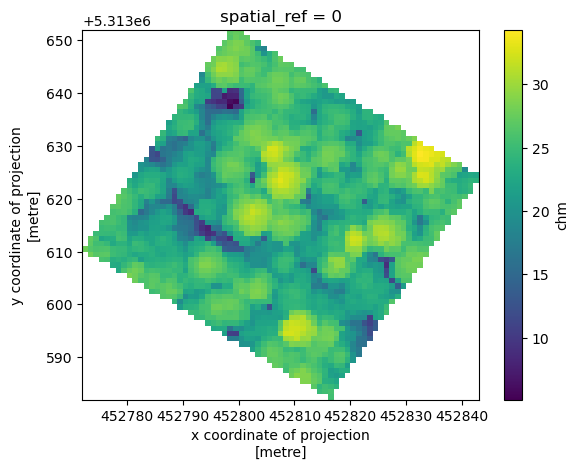

In [6]:
test_metrics['chm'].plot()

In [7]:
%%time

calculate_and_save_metrics_for_plot("AGG_O_01_P1")

Read in 289,504 points
CPU times: user 8.8 s, sys: 96.3 ms, total: 8.89 s
Wall time: 8.69 s


(4355, 78390)

In [8]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:58910,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:58923,Total threads: 2
Dashboard: http://127.0.0.1:58928/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:58913,


In [9]:
%%time

plot_ids = plots.index.to_list()
futures = client.map(calculate_and_save_metrics_for_plot, plot_ids, key=plot_ids, retries=2)
results = client.gather(futures)

Read in 156,666 points
Read in 289,504 points
Read in 163,491 points
Read in 260,541 points
Read in 317,786 points
Read in 329,862 points
Read in 331,415 points
Read in 162,691 points
Read in 186,879 points
Read in 162,146 points
Read in 174,304 points
Read in 146,138 points
Read in 146,470 points
Read in 182,817 points
Read in 152,496 points
Read in 145,274 points
Read in 122,901 points
Read in 214,515 points
Read in 128,424 points
Read in 133,882 points
Read in 240,870 points
Read in 146,555 points
Read in 216,864 points
Read in 91,042 points
Read in 131,655 points
Read in 231,509 points
Read in 218,394 points
Read in 229,375 points
Read in 191,280 points
Read in 262,521 points
Read in 189,710 points
Read in 267,077 points
Read in 204,467 points
Read in 179,985 points


/Users/jgregory/Code/forest-structure-tools/.pixi/envs/default/lib/python3.13/site-packages/rasterio/features.py:392: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _rasterize(valid_shapes, out, transform, all_touched, merge_alg)
/Users/jgregory/Code/forest-structure-tools/.pixi/envs/default/lib/python3.13/site-packages/rasterio/features.py:392: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _rasterize(valid_shapes, out, transform, all_touched, merge_alg)
/Users/jgregory/Code/forest-structure-tools/.pixi/envs/default/lib/python3.13/site-packages/rasterio/features.py:392: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _rasterize(valid_shapes, out, transform, all_touched, merge_alg)


Read in 177,682 points
Read in 184,695 points
Read in 130,689 points
Read in 204,748 points
Read in 123,530 points
Read in 290,305 points
Read in 200,361 points
Read in 158,400 points
Read in 242,769 points
Read in 158,585 points
Read in 185,002 points
Read in 329,464 points
Read in 196,108 points
Read in 229,277 points
Read in 123,853 points
Read in 270,637 points
Read in 126,631 points
Read in 293,835 points
Read in 109,745 points
Read in 88,300 points
Read in 130,419 points
Read in 301,500 points
Read in 254,980 points
Read in 360,945 points
Read in 291,500 points
Read in 140,119 points
Read in 305,103 points
Read in 334,848 points
Read in 170,659 points
Read in 108,059 points
Read in 107,652 points
Read in 381,564 points
Read in 95,979 points
Read in 107,120 points
Read in 137,216 points
Read in 124,467 points
Read in 124,218 points
Read in 374,320 points
Read in 191,797 points
Read in 100,672 points
Read in 105,958 points
Read in 150,286 points
Read in 194,972 points
Read in 299,5

/Users/jgregory/Code/forest-structure-tools/.pixi/envs/default/lib/python3.13/site-packages/rasterio/features.py:392: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _rasterize(valid_shapes, out, transform, all_touched, merge_alg)


Read in 158,834 points
Read in 308,978 points
Read in 175,456 points
Read in 169,607 points
Read in 546,515 points
Read in 232,627 points
Read in 244,175 points
Read in 199,096 points
Read in 136,888 points
Read in 362,786 points
Read in 98,056 points
Read in 169,226 points
Read in 115,997 points
Read in 121,243 points
Read in 179,562 points
Read in 233,745 points
Read in 197,634 points
Read in 242,487 points
Read in 148,031 points
Read in 185,326 points
Read in 111,328 points
Read in 176,452 points
Read in 94,739 points
Read in 196,646 points
Read in 233,792 points
Read in 111,656 points
Read in 114,648 points
Read in 163,478 points
Read in 213,364 points
Read in 98,175 points
Read in 173,741 points
Read in 123,147 points
Read in 92,580 points
Read in 100,934 points
Read in 122,644 points
Read in 186,091 points
Read in 200,051 points
Read in 161,772 points
Read in 125,391 points
Read in 226,393 points
Read in 191,908 points
Read in 174,495 points
Read in 67,357 points
Read in 138,403 

In [10]:
client.close()

In [12]:
total_grid = 0
total_voxel = 0
for result in results:
    grid, voxel = result
    total_grid += grid
    total_voxel += voxel

print(f"Total grid cells: {total_grid:,}")
print(f"Total voxel cells: {total_voxel:,}")


Total grid cells: 1,231,914
Total voxel cells: 43,776,960
